In [72]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay
import os
tf.config.set_visible_devices([], 'GPU')

---------------

**Obtain the Data: Get the Dogs vs Cats dataset (see class' notebook, only 5000, not 25,000, images are required, these image set is defined in the notebook)**

In [55]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook

data_folder = pathlib.Path("/Users/nasr/Cons_Code/CSCN8010_Main/Datasets/archive/train/kaggle_dogs_vs_cats_small")

In [56]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


-----

**EDA: Explore the data with relevant graphs, statistics and insights (5 points)**

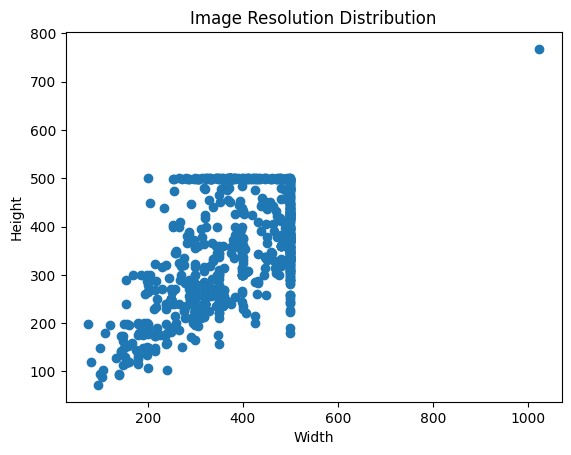

In [59]:
from PIL import Image
import os
import matplotlib.pyplot as plt

image_sizes = []
folder_path = "/Users/nasr/Cons_Code/CSCN8010_Main/Datasets/archive/train/kaggle_dogs_vs_cats_small/train/cat"

for img_file in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    image_sizes.append(img.size)

plt.scatter(*zip(*image_sizes))
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Distribution")
plt.show()


**The scatter plot shows the relationship between image width and height, with most resolutions clustered between 200–500 for width and 100–500 for height. A notable outlier at (1000, 800) suggests an unusually large image. This highlights the dataset's consistency, with potential preprocessing needed for outliers to ensure uniformity.**

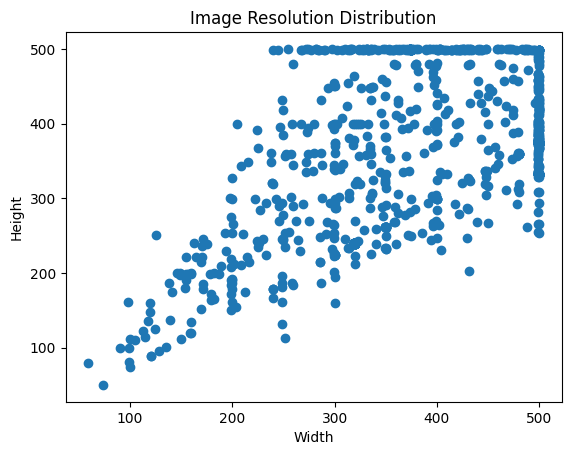

In [58]:
from PIL import Image
import os
import matplotlib.pyplot as plt

image_sizes = []
folder_path = "/Users/nasr/Cons_Code/CSCN8010_Main/Datasets/archive/train/kaggle_dogs_vs_cats_small/train/dog"

for img_file in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    image_sizes.append(img.size)

plt.scatter(*zip(*image_sizes))
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Distribution")
plt.show()


**The scatter plot shows most image resolutions clustered between 100–500 for both width and height, indicating consistent aspect ratios. A boundary at height ~500 suggests a common maximum resolution. The spread suggests diversity in sizes within this range, useful for preprocessing or standardizing images for consistent analysis or modeling.**

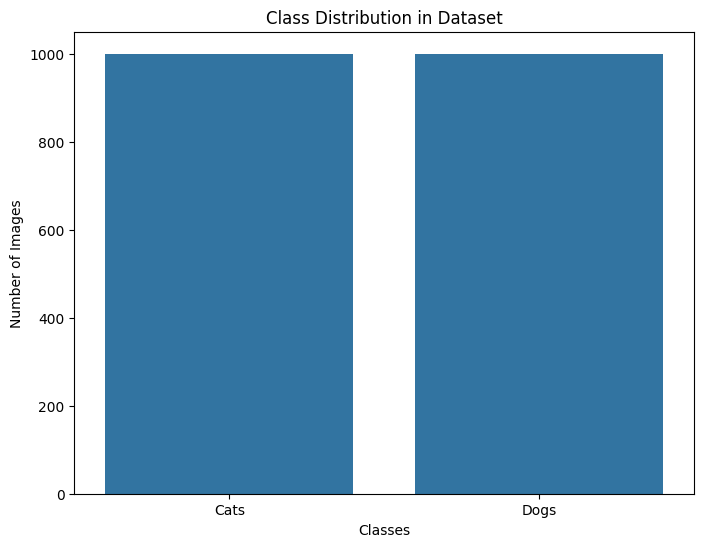

In [64]:
# Directories for dataset
cats_dir = "/Users/nasr/Cons_Code/CSCN8010_Main/Datasets/archive/train/kaggle_dogs_vs_cats_small/train/cat"
dogs_dir = "/Users/nasr/Cons_Code/CSCN8010_Main/Datasets/archive/train/kaggle_dogs_vs_cats_small/train/dog"

# Count the images in each directory
cats_count = len([img for img in os.listdir(cats_dir) if img.endswith(('png', 'jpg', 'jpeg'))])
dogs_count = len([img for img in os.listdir(dogs_dir) if img.endswith(('png', 'jpg', 'jpeg'))])

# Plot the distribution
classes = ["Cats", "Dogs"]
counts = [cats_count, dogs_count]

plt.figure(figsize=(8, 6))
sns.barplot(x=classes, y=counts)
plt.title("Class Distribution in Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.show()

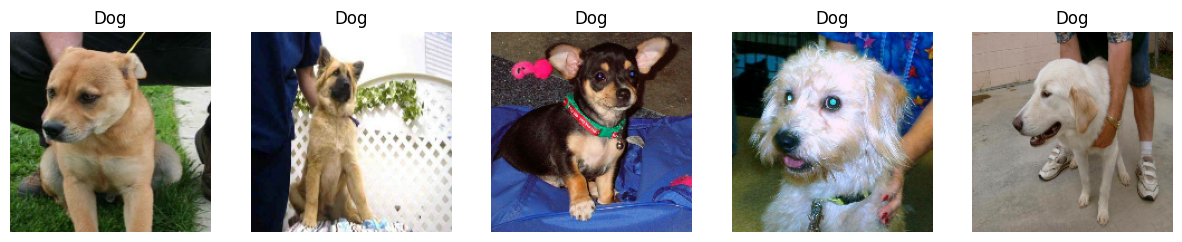

In [65]:
# Function to display sample images
def display_samples(dataset, class_names, num_samples=5):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.show()

# Display samples from training dataset
display_samples(train_dataset, class_names)

------

**Define a Neural Network of your choice (3 points)**

In [66]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [67]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

In [68]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [43]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 25s 383ms/step - loss: 0.7008 - accuracy: 0.5175 - val_loss: 0.6904 - val_accuracy: 0.5910
Epoch 2/30


/Users/nasr/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 28s 438ms/step - loss: 0.6893 - accuracy: 0.5805 - val_loss: 0.6639 - val_accuracy: 0.5760
Epoch 3/30
63/63 [==============================] - 24s 386ms/step - loss: 0.6544 - accuracy: 0.6320 - val_loss: 0.5939 - val_accuracy: 0.6770
Epoch 4/30
63/63 [==============================] - 24s 385ms/step - loss: 0.5941 - accuracy: 0.6895 - val_loss: 0.6003 - val_accuracy: 0.6780
Epoch 5/30
63/63 [==============================] - 24s 385ms/step - loss: 0.5616 - accuracy: 0.7155 - val_loss: 0.8256 - val_accuracy: 0.6770
Epoch 6/30
63/63 [==============================] - 24s 382ms/step - loss: 0.5414 - accuracy: 0.7355 - val_loss: 0.5897 - val_accuracy: 0.6720
Epoch 7/30
63/63 [==============================] - 24s 382ms/step - loss: 0.5092 - accuracy: 0.7440 - val_loss: 1.3723 - val_accuracy: 0.5750
Epoch 8/30
63/63 [==============================] - 24s 385ms/step - loss: 0.4845 - accuracy: 0.7800 - val_loss: 0.5178 - val_accuracy: 0.7570
Epoch 9/30

In [107]:
# Evaluate accuracy
test_model_CNN = load_model("./models/convnet_from_scratch.h5")
test_loss, test_accuracy = test_model_CNN.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")


63/63 [==============================] - 7s 106ms/step - loss: 0.5689 - accuracy: 0.7310
Test Accuracy: 0.73


63/63 [==============================] - 7s 105ms/step - loss: 0.5689 - accuracy: 0.7310


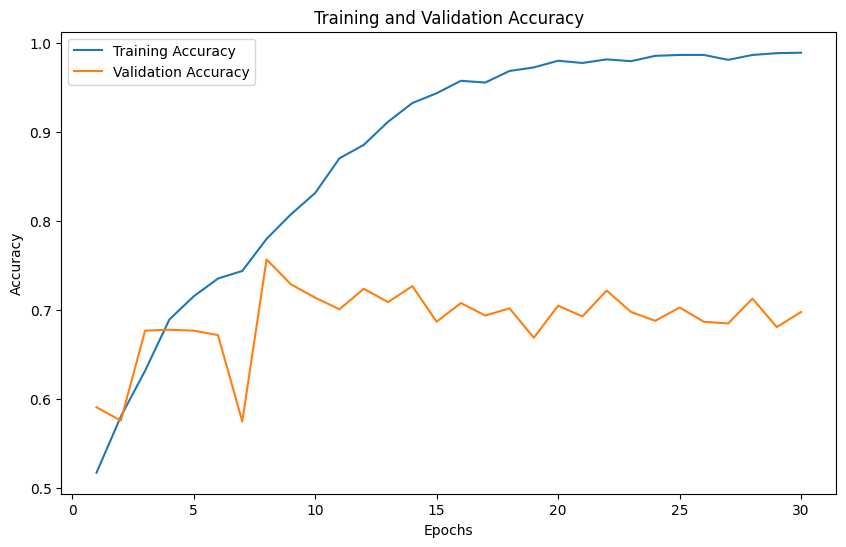

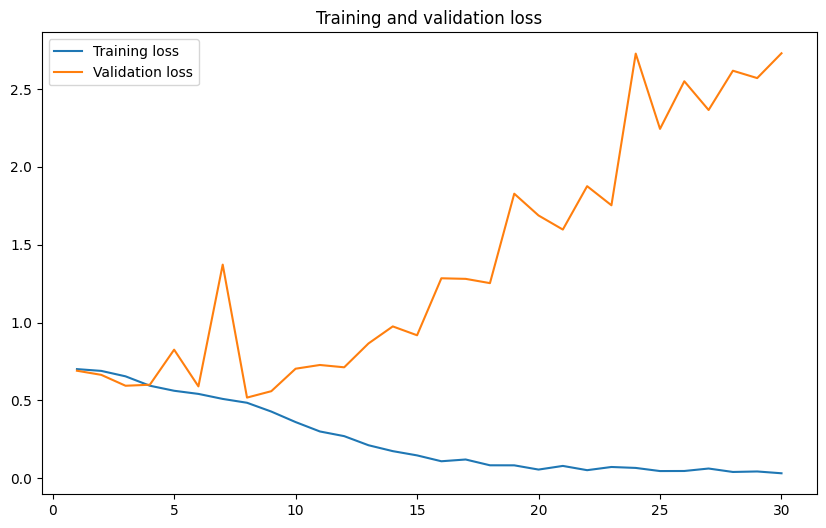

In [108]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = test_model_CNN.evaluate(test_dataset)

# Plot training and validation accuracy
history_dict = history.history
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, history_dict["accuracy"], label="Training Accuracy")
plt.plot(epochs, history_dict["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss , label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


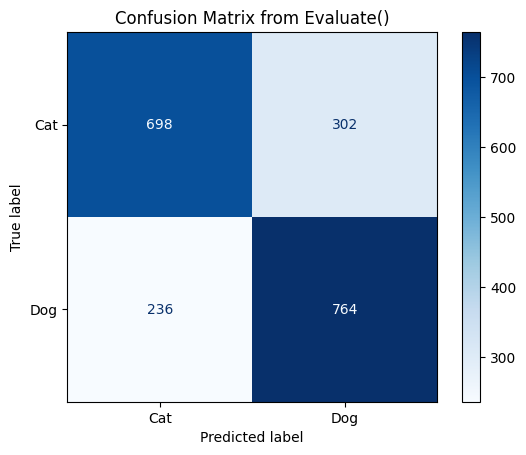

Classification Report:
              precision    recall  f1-score   support

         Cat       0.75      0.70      0.72      1000
         Dog       0.72      0.76      0.74      1000

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



In [109]:
# Step 1: Initialize arrays to collect true labels and predictions
y_true = []
y_pred = []

# Step 2: Use `evaluate()` loop to populate `y_true` and `y_pred`
for images, labels in test_dataset:
    outputs = test_model_CNN(images, training=False)  # Get outputs from the model during evaluation
    y_true.extend(labels.numpy())  # Append true labels
    y_pred.extend((outputs.numpy() > 0.5).astype(int))  # Append binary predictions

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 3: Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix from Evaluate()")
plt.show()

# Generate classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))



Best Threshold: 0.34058359265327454
Precision: 0.6779661016949152
Recall: 0.88
F1 Score: 0.7658833768494344


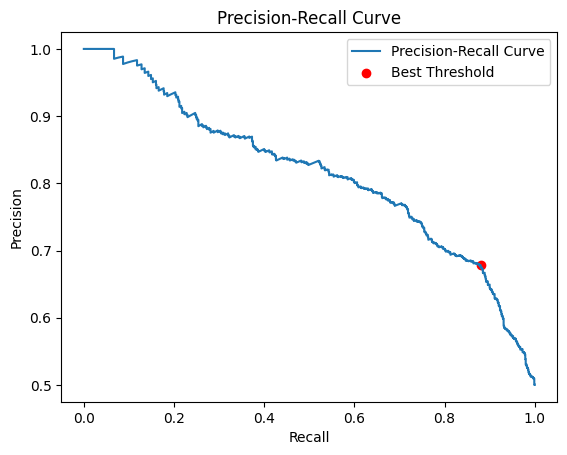

In [110]:
# Step 1: Initialize arrays to collect true labels and predictions
y_true = []
y_scores = []  # To collect the predicted scores (probabilities)

# Step 2: Use `evaluate()` loop to populate `y_true` and `y_scores`
for images, labels in test_dataset:
    outputs = test_model_CNN(images, training=False)  # Get outputs from the model during evaluation
    y_true.extend(labels.numpy())  # Append true labels
    y_scores.extend(outputs.numpy())  # Append predicted probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Step 3: Compute precision and recall
precision, recall, _ = precision_recall_curve(y_true, y_scores)



precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute the F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold with the highest F1 score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print(f"Best Threshold: {best_threshold}")
print(f"Precision: {precision[best_index]}")
print(f"Recall: {recall[best_index]}")
print(f"F1 Score: {f1_scores[best_index]}")

# Optional: Plot the Precision-Recall curve
import matplotlib.pyplot as plt

plt.plot(recall, precision, label="Precision-Recall Curve")
plt.scatter(recall[best_index], precision[best_index], color='red', label="Best Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

-------

**Fine-Tune VGG16 (pre-trained on imagenet).**

**Part One - Extract the features from imagenet**

In [76]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [77]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [7]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 818ms/step


In [13]:
train_features.shape

(2000, 5, 5, 512)

In [14]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3277313 (12.50 MB)
Trainable params: 3277313 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      #filepath="./models/feature_extraction.keras",
      filepath="./models/feature_extraction.h5",
      save_best_only=True,
      monitor="val_loss"),
      
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 11ms/step - loss: 18.4988 - accuracy: 0.9165 - val_loss: 3.3504 - val_accuracy: 0.9730
Epoch 2/20
22/63 [=========>....................] - ETA: 0s - loss: 1.8451 - accuracy: 0.9830

/Users/nasr/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 1s 9ms/step - loss: 2.1687 - accuracy: 0.9810 - val_loss: 6.8124 - val_accuracy: 0.9600
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 2.6540 - accuracy: 0.9830 - val_loss: 6.6890 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1.0372 - accuracy: 0.9895 - val_loss: 4.0294 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 1.2032 - accuracy: 0.9900 - val_loss: 20.9365 - val_accuracy: 0.9250
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 1.4657 - accuracy: 0.9875 - val_loss: 6.5768 - val_accuracy: 0.9710
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 0.2485 - accuracy: 0.9970 - val_loss: 9.3580 - val_accuracy: 0.9650
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 0.3921 - accuracy: 0.9940 - val_loss: 6.6312 - val_accuracy: 0.9710
Epoch 9/20
63/63 [============

In [111]:
test_model_VGG_1= keras.models.load_model("./models/feature_extraction.h5")
test_loss, test_acc = test_model_VGG_1.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 3.8255 - accuracy: 0.9680
Test accuracy: 0.968


----------------- 



**Part Two - Fine Tune by VGG16 to predict depending on features from imagenet**

In [8]:
from tensorflow.keras import layers, models, applications

In [19]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [22]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_5  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_5 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0   

In [30]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_Tune_Augmented.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 154s 2s/step - loss: 16.3690 - accuracy: 0.8940 - val_loss: 4.7597 - val_accuracy: 0.9680
Epoch 2/50
63/63 [==============================] - 156s 2s/step - loss: 8.2327 - accuracy: 0.9425 - val_loss: 5.5284 - val_accuracy: 0.9710
Epoch 3/50
63/63 [==============================] - 159s 3s/step - loss: 6.0524 - accuracy: 0.9520 - val_loss: 4.1663 - val_accuracy: 0.9760
Epoch 4/50
63/63 [==============================] - 160s 3s/step - loss: 5.5817 - accuracy: 0.9550 - val_loss: 4.8645 - val_accuracy: 0.9710
Epoch 5/50
63/63 [==============================] - 160s 3s/step - loss: 3.8044 - accuracy: 0.9700 - val_loss: 4.8918 - val_accuracy: 0.9670
Epoch 6/50
63/63 [==============================] - 159s 3s/step - loss: 2.5319 - accuracy: 0.9695 - val_loss: 3.8677 - val_accuracy: 0.9810
Epoch 7/50
63/63 [==============================] - 1308s 21s/step - loss: 3.6349 - accuracy: 0.9700 - val_loss: 3.3360 - val_accuracy: 0.9780
Epoch 8/50

In [112]:
test_model_VGG_2 = keras.models.load_model( "./models/fine_Tune_Augmented.h5")
test_loss, test_acc = test_model_VGG_2.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 125s 2s/step - loss: 2.5907 - accuracy: 0.9770
Test accuracy: 0.977


63/63 [==============================] - 123s 2s/step - loss: 2.5907 - accuracy: 0.9770


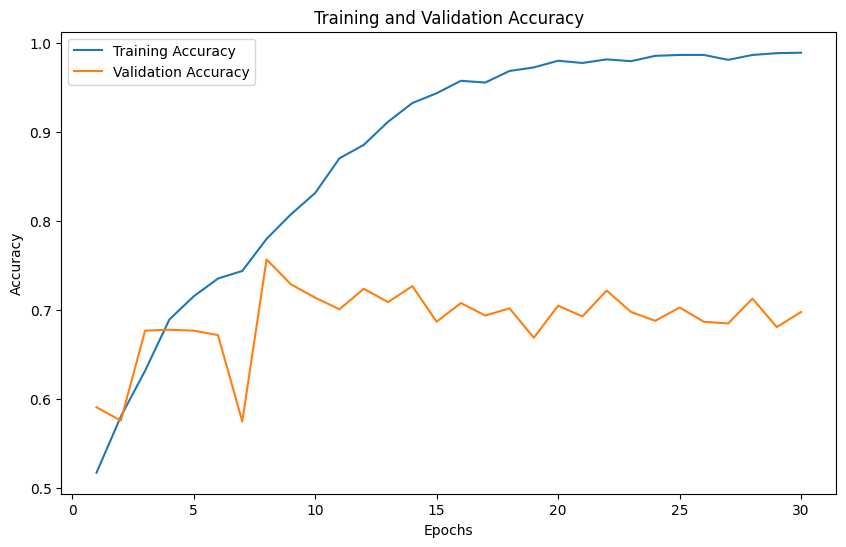

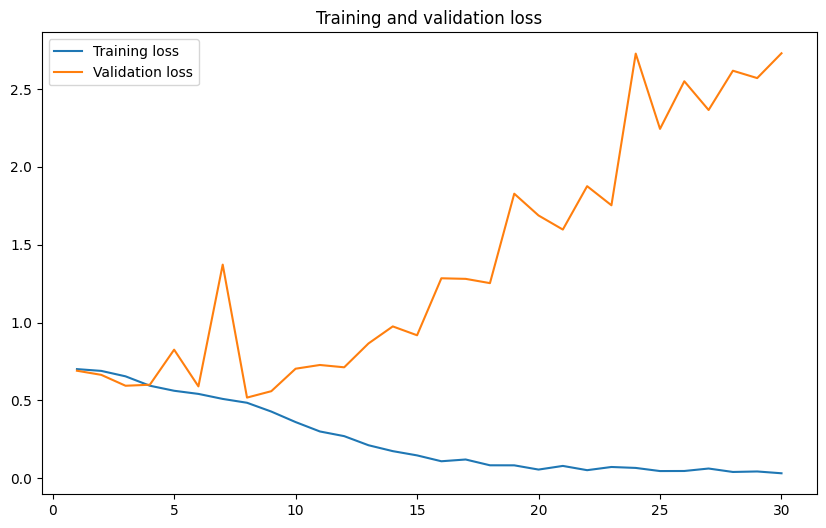

In [113]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = test_model_VGG_2.evaluate(test_dataset)

# Plot training and validation accuracy
history_dict = history.history
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, history_dict["accuracy"], label="Training Accuracy")
plt.plot(epochs, history_dict["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss , label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


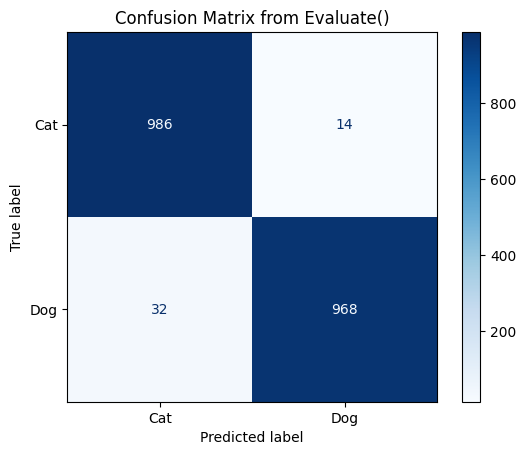

Classification Report:
              precision    recall  f1-score   support

         Cat       0.97      0.99      0.98      1000
         Dog       0.99      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [114]:
# Step 1: Initialize arrays to collect true labels and predictions
y_true = []
y_pred = []

# Step 2: Use `evaluate()` loop to populate `y_true` and `y_pred`
for images, labels in test_dataset:
    outputs = test_model_VGG_2(images, training=False)  # Get outputs from the model during evaluation
    y_true.extend(labels.numpy())  # Append true labels
    y_pred.extend((outputs.numpy() > 0.5).astype(int))  # Append binary predictions

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 3: Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix from Evaluate()")
plt.show()

# Generate classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

Best Threshold: 0.34058359265327454
Precision: 0.6779661016949152
Recall: 0.88
F1 Score: 0.7658833768494344


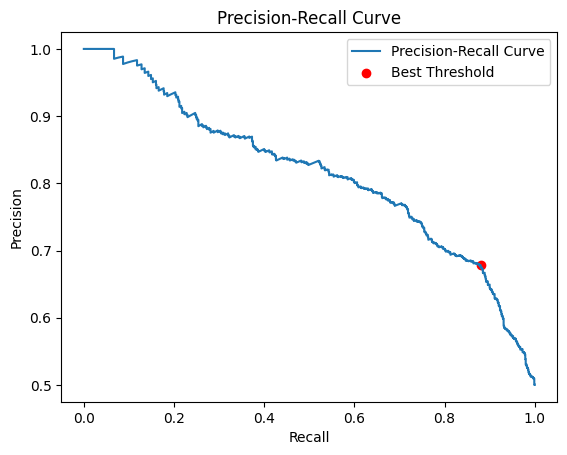

In [115]:
# Step 1: Initialize arrays to collect true labels and predictions
y_true = []
y_scores = []  # To collect the predicted scores (probabilities)

# Step 2: Use `evaluate()` loop to populate `y_true` and `y_scores`
for images, labels in test_dataset:
    outputs = test_model_CNN(images, training=False)  # Get outputs from the model during evaluation
    y_true.extend(labels.numpy())  # Append true labels
    y_scores.extend(outputs.numpy())  # Append predicted probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Step 3: Compute precision and recall
precision, recall, _ = precision_recall_curve(y_true, y_scores)



precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute the F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold with the highest F1 score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print(f"Best Threshold: {best_threshold}")
print(f"Precision: {precision[best_index]}")
print(f"Recall: {recall[best_index]}")
print(f"F1 Score: {f1_scores[best_index]}")

# Optional: Plot the Precision-Recall curve
import matplotlib.pyplot as plt

plt.plot(recall, precision, label="Precision-Recall Curve")
plt.scatter(recall[best_index], precision[best_index], color='red', label="Best Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

--------------

### Explore specific examples in which the model failed to predict correctly.

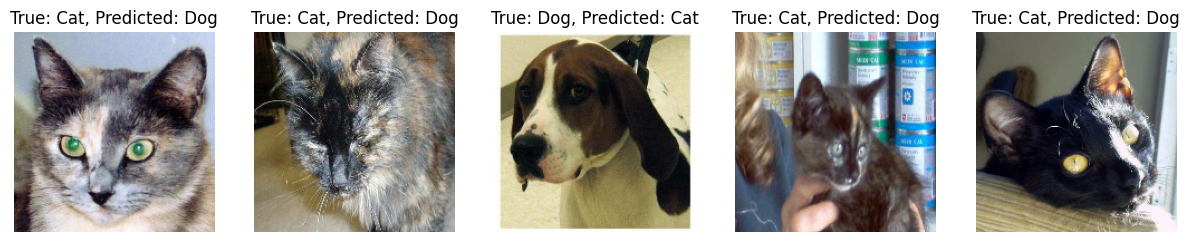

In [116]:
# Function to display misclassified examples
def display_failures(test_dataset, model, class_names, num_failures=5):
    
    count = 0
    plt.figure(figsize=(15, 10))
    for images, labels in test_dataset.unbatch():
        # Get the model's output
        outputs = model(images[None, ...], training=False)  # Add batch dimension
        prediction = (outputs.numpy() > 0.5).astype(int)  # Binary prediction (0 or 1)

        # Check if the prediction is incorrect
        if prediction[0][0] != labels.numpy():
            count += 1
            plt.subplot(1, num_failures, count)
            plt.imshow(images.numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels.numpy()]}, Predicted: {class_names[prediction[0][0]]}")
            plt.axis("off")

            if count == num_failures:
                break
    plt.show()

# Class names for the dataset
class_names = ["Cat", "Dog"]

# Call the function to display 5 misclassified examples
display_failures(test_dataset, test_model_CNN, class_names, num_failures=5)


## Final Conclusions

- **The improvements are very significant when the VGG model is compared to the Vanilla model on all metrics; especially, precision, recall, and F1-score show almost perfect accuracy.**
- **The deeper and more complex architecture of the VGG model contributes to an improved capability in finding features that help distinguish between cats and dogs.**